In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from IPython.display import clear_output
import nibabel as nib
import glob 
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from PIL import Image
from fastprogress import master_bar, progress_bar
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
clear_output()
NUM_CLASS = 2

In [ ]:
# %cd /content/drive/MyDrive/dataISIC2018

/content/drive/MyDrive/dataISIC2018


In [ ]:
# all_train_files = glob.glob("/content/drive/MyDrive/deepfish/Dataset/LargeFish/Fish_Dataset/*/*/*.png")
# train_gt_files = glob.glob("/content/drive/MyDrive/deepfish/Dataset/LargeFish/Fish_Dataset/*/* GT/*.png")
# train_image_files = list(set(all_train_files) - set(train_gt_files))

# train_image_files = np.array(sorted(train_image_files))
# train_gt_files = np.array(sorted(train_gt_files))

# len(train_image_files), len(train_gt_files)
# x_train, x_val, y_train, y_val = train_test_split(train_image_files, train_gt_files, test_size = 0.2, random_state=42)

In [ ]:
# size=(128, 128)
# idx = 1000
# a = Image.open(y_train[idx]).resize((size[1], size[0]), Image.NEAREST)
# image = Image.open(x_train[idx]).resize((size[1], size[0]))

In [ ]:
def get_data(train_path, mask_path, size=(128, 128)):
    from tqdm import tqdm
    images, masks = [], []
    for idx in tqdm(range(len(train_path))):
        image = Image.open(train_path[idx]).resize((size[1], size[0]))
        mask = Image.open(mask_path[idx]).resize((size[1], size[0]), Image.NEAREST)
        mask = np.asarray(mask, dtype=np.uint8)
        images.append(image)
        masks.append(mask)
    return np.stack(images), np.stack(masks)

In [ ]:
# x, y = get_data(train_image_files, train_gt_files)

In [ ]:
# np.savez_compressed('/content/drive/MyDrive/deepfish/Dataset/largeFish_128', image=x, mask=y)

In [ ]:
# data = np.load("/content/drive/MyDrive/new_paper/ISIC/dataISIC2018/ISIC2018_192_256.npz")
# x,y = data["image"], data["mask"]

In [ ]:
class RandomCrop(transforms.RandomResizedCrop):
    def __call__(self, imgs):
        i, j, h, w = self.get_params(imgs[0], self.scale, self.ratio)
        for imgCount in range(len(imgs)):
            imgs[imgCount] = transforms.functional.resized_crop(imgs[imgCount], i, j, h, w, self.size, self.interpolation)
        return imgs
class FishLoader(Dataset):
    def __init__(self, images, masks, 
                 transform=True, typeData="train", size=(128, 128), loadFromPath=True):
        self.transform = transform if typeData == "train" else False  # augment data bool
        self.typeData = typeData
        self.images = images
        self.masks = masks
        self.size = size
        self.loadFromPath = loadFromPath
    def __len__(self):
        return len(self.images)

    def rotate(self, image, mask, degrees=(-15,15), p=0.1):
        if torch.rand(1) < p:
            degree = np.random.uniform(*degrees)
            image = image.rotate(degree, Image.NEAREST)
            mask = mask.rotate(degree, Image.NEAREST)
        return image, mask
    def horizontal_flip(self, image, mask, p=0.5):
        if torch.rand(1) < p:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        return image, mask
    def vertical_flip(self, image, mask, p=0.5):
        if torch.rand(1) < p:
            image = image.transpose(Image.FLIP_TOP_BOTTOM)
            mask = mask.transpose(Image.FLIP_TOP_BOTTOM)
        return image, mask
    def random_resized_crop(self, image, mask, p=0.5):
        if torch.rand(1) < p:
            image, mask = RandomCrop(self.size, scale=(0.8, 0.95))([image, mask])
        return image, mask

    def augment(self, image, mask):
        image, mask = self.random_resized_crop(image, mask)
        image, mask = self.rotate(image, mask)
        image, mask = self.horizontal_flip(image, mask)
        image, mask = self.vertical_flip(image, mask)
        return image, mask

    def __getitem__(self, idx):
        if self.loadFromPath:
            image = Image.open(self.images[idx]).resize((self.size[1], self.size[0]))
            mask = Image.open(self.masks[idx]).resize((self.size[1], self.size[0]), Image.NEAREST)
        else :
            image = Image.fromarray(self.images[idx])
            mask = Image.fromarray(self.masks[idx])

    ####################### augmentation data ##############################
        if self.transform:
            image, mask = self.augment(image, mask)
        image = transforms.ToTensor()(image)
        mask = np.asarray(mask, np.int64)
        mask = torch.from_numpy(mask[np.newaxis])
        return image, mask

In [ ]:
# load = iter(FishLoader(x_train, y_train, transform=True))

In [ ]:
# image, mask = next(load)

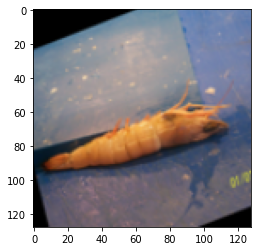

In [ ]:
# plt.imshow(image.permute(1,2,0))

In [ ]:
# torch.unique(mask)

tensor([0, 1])

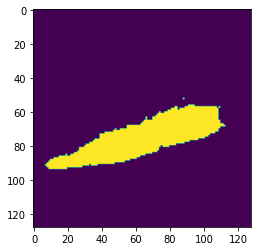

In [ ]:
# plt.imshow(mask[0])

##loss

In [ ]:
class SemiActiveLoss(nn.Module):
    def __init__(self, device, alpha =1e-9, beta = 1e-1, lamda = 1e-3):
        super().__init__()
        self.device = device
        self.alpha = alpha
        self.beta = beta      
        self.lamda = lamda
    def LevelsetLoss(self, image, y_pred, kernel_size=5, smooth=1e-5):
        kernel = torch.ones(1, y_pred.size(1), kernel_size, kernel_size, device=self.device) / kernel_size**2
        padding = kernel_size //2
        lossRegion = 0.0
        y_pred_fuzzy = y_pred 
        for ich in range(image.size(1)):
            target_ = image[:,ich:ich+1] 
            pcentroid_local = F.conv2d(target_ * y_pred_fuzzy + smooth, kernel, padding = padding) \
                                / F.conv2d(y_pred_fuzzy + smooth, kernel, padding = padding)
            plevel_local = target_ - pcentroid_local
            loss_local = plevel_local * plevel_local * y_pred_fuzzy

            pcentroid_global = torch.sum(target_ * y_pred_fuzzy, dim=(2,3),keepdim=True) \
                                / torch.sum(y_pred_fuzzy+smooth, dim=(2,3),keepdim = True)   
            plevel_global = target_ - pcentroid_global
            loss_global = plevel_global * plevel_global * y_pred_fuzzy

            lossRegion += torch.sum(loss_local) + self.beta * torch.sum(loss_global)
        return lossRegion 
    def GradientLoss(self, y_pred, penalty = "l1"):
        dH = torch.abs(y_pred[...,1:] - y_pred[...,:-1])
        dW = torch.abs(y_pred[:,:,1:] - y_pred[:,:,:-1])
        if penalty == "l2":
            dH = dH * dH
            dW = dW * dW
        loss =  torch.sum(dH) +  torch.sum(dW)
        return loss
    def ActiveContourLoss(self, y_true, y_pred, smooth=1e-11):   
        dim = (1,2,3)
        yTrueOnehot = torch.zeros(y_true.size(0), NUM_CLASS, y_true.size(2), y_true.size(3), device=self.device)
        yTrueOnehot = torch.scatter(yTrueOnehot, 1, y_true, 1)[:,1:]
        y_pred = y_pred[:,1:]

        active = - torch.log(1-y_pred+smooth) * (1-yTrueOnehot) - torch.log(y_pred+smooth) * yTrueOnehot
        loss = torch.sum(active, dim = dim) / torch.sum(yTrueOnehot + y_pred - yTrueOnehot * y_pred + smooth, dim = dim)
        return torch.mean(loss)

    def forward(self, image, y_true, y_pred):
        active = self.ActiveContourLoss(y_true, y_pred)
        levelset =  self.LevelsetLoss(image, y_pred)
        length = self.GradientLoss(y_pred)
        return active + self.alpha * (levelset + self.lamda * length) 
class CrossEntropy(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device
    def forward(self, y_true, y_pred):   
        yTrueOnehot = torch.zeros(y_true.size(0), NUM_CLASS, y_true.size(2), y_true.size(3), device=self.device)
        yTrueOnehot = torch.scatter(yTrueOnehot, 1, y_true, 1)

        loss = torch.sum(-yTrueOnehot * torch.log(y_pred+1e-10))
        return loss / (y_true.size(0) * y_true.size(2) * y_true.size(3))
class DiceLoss(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device
    def forward(self, y_true, y_pred):   
        yTrueOnehot = torch.zeros(y_true.size(0), NUM_CLASS, y_true.size(2), y_true.size(3), device=self.device)
        yTrueOnehot = torch.scatter(yTrueOnehot, 1, y_true, 1)[:, 1:]
        y_pred = y_pred[:,1:]

        intersection = torch.sum(yTrueOnehot * y_pred, dim=[1,2,3])
        cardinality  = torch.sum(yTrueOnehot + y_pred , dim=[1,2,3])
        loss = 1.0-torch.mean((2. * intersection + 1e-5) / (cardinality + 1e-5))
        return loss

##metrics

In [ ]:
def dice(y_true, y_pred, smooth = 1e-4):
    y_pred = torch.argmax(y_pred, dim=1, keepdim = True)
    intersection = torch.sum(y_true * y_pred, dim=[1,2,3])
    cardinality  = torch.sum(y_true + y_pred , dim=[1,2,3])
    return torch.mean((2. * intersection + smooth) / (cardinality + smooth), dim=0)

def jaccard(y_true, y_pred, smooth = 1e-4):
    y_pred = torch.argmax(y_pred, dim=1, keepdim = True)
    intersection = torch.sum(y_true * y_pred, dim=[1,2,3])
    union = torch.sum(y_true + y_pred , dim=[1,2,3]) - intersection
    return torch.mean((intersection + smooth) / (union + smooth), dim=0)


##optimizer

In [ ]:
import math
import torch
from torch.optim.optimizer import Optimizer


class Nadam(Optimizer):
    """Implements Nadam algorithm (a variant of Adam based on Nesterov momentum).
    It has been proposed in `Incorporating Nesterov Momentum into Adam`__.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 2e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        schedule_decay (float, optional): momentum schedule decay (default: 4e-3)
    __ http://cs229.stanford.edu/proj2015/054_report.pdf
    __ http://www.cs.toronto.edu/~fritz/absps/momentum.pdf
        Originally taken from: https://github.com/pytorch/pytorch/pull/1408
        NOTE: Has potential issues but does work well on some problems.
    """

    def __init__(self, params, lr=2e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, schedule_decay=4e-3):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        defaults = dict(
            lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, schedule_decay=schedule_decay)
        super(Nadam, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['m_schedule'] = 1.
                    state['exp_avg'] = torch.zeros_like(p)
                    state['exp_avg_sq'] = torch.zeros_like(p)

                # Warming momentum schedule
                m_schedule = state['m_schedule']
                schedule_decay = group['schedule_decay']
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                eps = group['eps']
                state['step'] += 1
                t = state['step']
                bias_correction2 = 1 - beta2 ** t

                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])

                momentum_cache_t = beta1 * (1. - 0.5 * (0.96 ** (t * schedule_decay)))
                momentum_cache_t_1 = beta1 * (1. - 0.5 * (0.96 ** ((t + 1) * schedule_decay)))
                m_schedule_new = m_schedule * momentum_cache_t
                m_schedule_next = m_schedule * momentum_cache_t * momentum_cache_t_1
                state['m_schedule'] = m_schedule_new

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1. - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1. - beta2)

                denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(eps)
                p.addcdiv_(grad, denom, value=-group['lr'] * (1. - momentum_cache_t) / (1. - m_schedule_new))
                p.addcdiv_(exp_avg, denom, value=-group['lr'] * momentum_cache_t_1 / (1. - m_schedule_next))

        return loss

In [ ]:
# train_input = sorted(glob.glob("/content/ISIC2018_Task1-2_Training_Input/*jpg"))
# train_gt = sorted(glob.glob("/content/ISIC2018_Task1_Training_GroundTruth/*png"))
# valid_input = sorted(glob.glob("/content/ISIC2018_Task1-2_Validation_Input/*jpg"))
# valid_gt = sorted(glob.glob("/content/ISIC2018_Task1_Validation_GroundTruth/*png"))
# inputs = valid_input + train_input
# gts = valid_gt + train_gt
# train_valid_test_split = (0.8, 0.1, 0.1)

# test_count = int(train_valid_test_split[2] * len(inputs))
# valid_count = test_count
# train_count = len(inputs) - test_count * 2

# all_files = np.array(list(zip(inputs, gts)))
# np.random.seed(42)
# np.random.shuffle(all_files)

# train_files = all_files[:train_count]
# valid_files = all_files[train_count : train_count + valid_count]
# test_files = all_files[-test_count:]

# def get_data(files, size=(192, 256)):
#     from tqdm import tqdm
#     images, masks = [], []
#     for input_file, gt_file in tqdm(files):
#         image = Image.open(input_file).resize((size[1], size[0]))
#         mask = Image.open(gt_file).resize((size[1], size[0]), Image.NEAREST)
#         mask = np.array(mask) // 255
#         images.append(image)
#         masks.append(mask)
#     return np.stack(images), np.stack(masks)
# x_train, y_train =  get_data(train_files) 
# x_val, y_val =  get_data(valid_files) 
# x_test, y_test =  get_data(test_files) 
# %cd /content/drive/MyDrive/dataISIC2018
# np.savez_compressed('ISIC2018_train', image=x_train, mask=y_train)
# np.savez_compressed('ISIC2018_val', image=x_val, mask=y_val)
# np.savez_compressed('ISIC2018_test', image=x_test, mask=y_test)
